## Two major categories of methods for recommender systems:
### 1. Collaborative filtering methods
 - Based solely on the past interactions recorded between users and items
    (e.g. rating given by a user to a movie, time spent by a reader on an article)
 - Memory based (works with values of recorded interactions, assuming no model, based on nearest neighbours search) and model based (assume an underlying "generative" model that explains the user-item interactions and try to discover it to make new predictions)

 - The more users interact with items, the more new recommendations become accurate
 - "Cold start problem" - impossible to recommend anything to new users/new item to users (recommend random items initially/recommend popular items to new users or new items to the most active users, etc.)



### 2. Content based methods
 - Use additional information about users and/or items (e.g. age, sex, job, and othe personal information)
 
 - Suffer far less from the "cold start problem" once sufficient users in the system


In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.utils import shuffle
import sklearn
from sklearn.decomposition import TruncatedSVD

import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# df = pd.read_csv("ratings_Electronics.csv")

# print(len(df))

7824481


# Pre-processing to extract relevant information and remove duplicates

In [9]:
# give column headers
df.columns = ['reviewerID','asin','overall','timestamp']

# basic information about ratings
df["overall"].describe()

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

In [10]:
# no. of unique reviewers
df['reviewerID'].nunique()

4201696

In [13]:
# remove duplicates if any

review = df.drop_duplicates(subset=['reviewerID', 'asin'], keep='last')
print(len(review))

7824481


# Change reviewerID and asin to numerical values and save as new csv

In [14]:
# give new_user_id based on reviewerID

current_user_id = 0
custom_user_map = {} 
def map_user_id(row):
    global current_user_id, custom_user_map
    old_user_id = row["reviewerID"]
    if old_user_id not in custom_user_map:
        custom_user_map[old_user_id] = current_user_id
        current_user_id += 1
    return custom_user_map[old_user_id]

review["new_user_id"] = review.apply(map_user_id, axis=1)

In [15]:
# give new_product_id based on asin

current_product_id = 0
custom_product_map = {} 
def map_product_id(row):
    global current_product_id, custom_product_map
    old_product_id = row["asin"]
    if old_product_id not in custom_product_map:
        custom_product_map[old_product_id] = current_product_id
        current_product_id += 1
    return custom_product_map[old_product_id]

review["new_product_id"] = review.apply(map_product_id, axis=1)

In [16]:
review.head()

,reviewerID,asin,overall,timestamp,new_user_id,new_product_id
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,0,0
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,1,1
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2,1
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,3,1
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600,4,2


In [19]:
review.to_csv('electronics_processed.csv')

# Basic information about data

## Product popularity based recommendation system targeted at new customers - use most popular products if no information initially

In [20]:
review = pd.read_csv("electronics_processed.csv")
review.head()

,Unnamed: 0,reviewerID,asin,overall,new_user_id,new_product_id
0,0,A2CX7LUOHB2NDG,0321732944,5.0,0,0
1,1,A2NWSAGRHCP8N5,0439886341,1.0,1,1
2,2,A2WNBOD3WNDNKT,0439886341,3.0,2,1
3,3,A1GI0U4ZRJA8WN,0439886341,1.0,3,1
4,4,A1QGNMC6O1VW39,0511189877,5.0,4,2


In [64]:
review[review.asin == "B0074BW614"]

,Unnamed: 0,reviewerID,asin,overall,new_user_id,new_product_id
5592209,5592209,A3501BQE45OX22,B0074BW614,4.0,3214509,308397
5592210,5592210,A2JOZUUH1FKZA5,B0074BW614,5.0,3214510,308397
5592211,5592211,A2SMTNHD4IY85U,B0074BW614,5.0,3214511,308397
5592212,5592212,A3HJD8GP1IAE7Y,B0074BW614,5.0,3214512,308397
5592213,5592213,AS1Y9OT3RCV86,B0074BW614,4.0,3214513,308397
...,...,...,...,...,...,...
5610448,5610448,A1B4G23001KWR0,B0074BW614,5.0,3226085,308397
5610449,5610449,A3QJKMPEJWX01W,B0074BW614,5.0,3117644,308397
5610450,5610450,A3Q09YAW0CGXPC,B0074BW614,4.0,3226086,308397
5610451,5610451,A1O3D41S3NAVTZ,B0074BW614,5.0,3226087,308397


In [21]:
# most popular products and their average ratings

popular_products = pd.DataFrame(review.groupby('asin')['overall'].count())
popular_products_ratings = pd.DataFrame(review.groupby('asin')['overall'].mean())
popular_products["average_ratings"] = popular_products_ratings["overall"]
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(10)

,overall,average_ratings
asin,,
B0074BW614,18244,4.491504
B00DR0PDNE,16454,3.931020
B007WTAJTO,14172,4.424005
B0019EHU8G,12285,4.754497
B006GWO5WK,12226,4.314657
B003ELYQGG,11617,4.392528
B003ES5ZUU,10276,4.704749
B007R5YDYA,9907,4.690926
B00622AG6S,9823,4.420136


<AxesSubplot:xlabel='asin'>

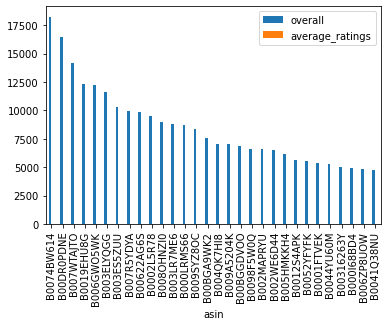

In [22]:
most_popular.head(30).plot(kind = "bar")

# Further data exploration

## Recomend similar items based on count, rating, and unreliability factor (k-nearest neighbors) - Memory based

In [92]:
product_rating = review.groupby('new_product_id')['overall'].mean()
product_rating.head()

new_product_id
0    5.000000
1    1.666667
2    4.500000
3    2.851852
4    3.000000
Name: overall, dtype: float64

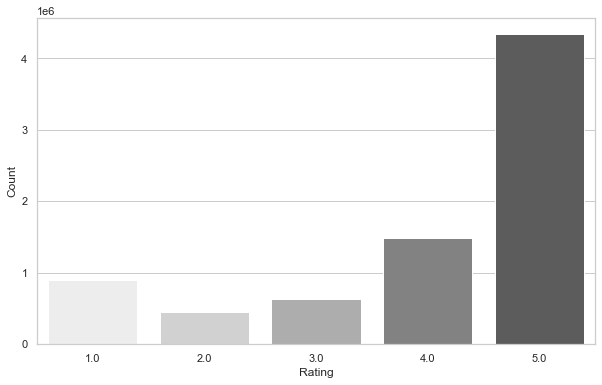

In [88]:
# figure to show proportion for each rating
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
ax = sns.countplot(x='overall', data=review, palette=sns.color_palette('Greys'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

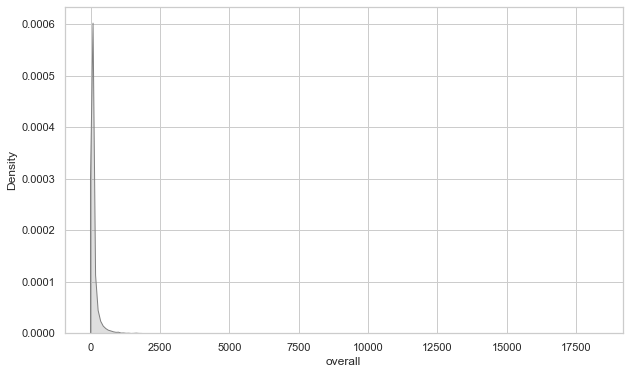

In [89]:
# Count of the number of ratings per Product

product_rating_count = review.groupby('new_product_id')['overall'].count()
ax = sns.kdeplot(product_rating_count, shade=True, color='grey')
plt.show()

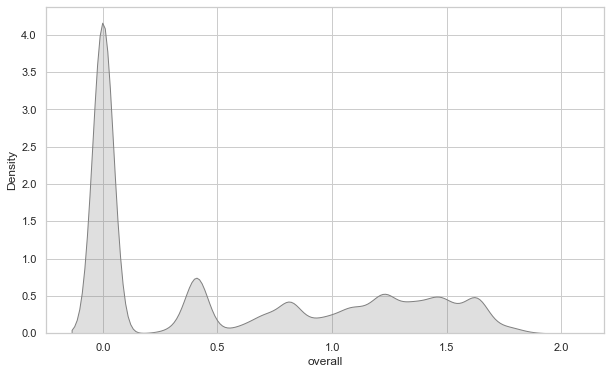

In [90]:
# Un-Reliability factor

unreliability = review.groupby('new_product_id')['overall'].std(ddof = -1)
ax = sns.kdeplot(unreliability, shade=True, color='grey')
plt.show()

In [94]:
unique_products_list = review.new_product_id.unique()
data_model = pd.DataFrame({'rating': product_rating[unique_products_list],\
                           'count': product_rating_count[unique_products_list], \
                          'unreliability': unreliability[unique_products_list]})
data_model.head()

,rating,count,unreliability
new_product_id,,,
0,5.000000,1,0.000000
1,1.666667,3,0.816497
2,4.500000,6,1.035098
3,2.851852,27,1.619164
4,3.000000,1,0.000000


In [95]:
data_model.shape

(476001, 3)

In [96]:
data_model["count"].describe()

count    476001.000000
mean         16.437951
std         112.702749
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       18244.000000
Name: count, dtype: float64

In [127]:
data_model_new = data_model[data_model["count"] > 10].copy()
print(data_model_new.shape)

(90897, 3)


In [128]:
# Normalization function to range 0 - 10

def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [129]:
data_model_norm = normalize(data_model_new)
data_model_norm.head()

,rating,count,unreliability
new_product_id,,,
3,4.629630,0.008775,8.344982
10,8.833333,0.002194,5.110753
17,8.392857,0.001645,6.129190
20,8.064516,0.010969,6.273896
21,8.461538,0.001097,6.323741


In [169]:
# Setting up the model

# Recommend 10 similar items
engine = KNeighborsClassifier(n_neighbors=10)

# Training data points
data_points = data_model_norm[['count', 'rating', 'unreliability']].values

#Training labels
labels = data_model_norm.index.values

print("Data points: ")
print(data_points)
print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[8.77529754e-03 4.62962963e+00 8.34498194e+00]
 [2.19382438e-03 8.83333333e+00 5.11075255e+00]
 [1.64536829e-03 8.39285714e+00 6.12918953e+00]
 ...
 [1.64536829e-03 8.03571429e+00 5.70152966e+00]
 [2.19382438e-03 8.00000000e+00 4.53717285e+00]
 [2.19382438e-03 7.50000000e+00 6.04346238e+00]]
Labels: 
[     3     10     17 ... 475879 475895 475999]


KNeighborsClassifier(n_neighbors=10)

In [170]:
# Enter product ID to get a list of 10 recommended items

# User entered value
product_id = 335458

product_data = [data_model_norm.loc[product_id][['count', 'rating', 'unreliability']].values]

recommended_products = engine.kneighbors(X=product_data, n_neighbors=10, return_distance=False)

# List of product IDs form the indexes

products_list = []

for each in recommended_products:
    products_list.append(data_model_norm.iloc[each].index)

print("Recommended products: ")
print(products_list)

Recommended products: 
[Int64Index([335458, 422455, 84705, 310924, 170288, 85339, 132840, 55601,
            285515, 419966],
           dtype='int64', name='new_product_id')]


In [171]:
items = review[review['new_product_id'].isin(products_list[0])]
items = items.drop_duplicates(subset=['asin'], keep='last')
items.sort_values(by=['new_product_id'])

,Unnamed: 0,reviewerID,asin,overall,new_user_id,new_product_id
944993,944993,AQRCB1KHUKZMD,B000FNH1MC,5.0,717978,55601
1478190,1478190,A3PIVVHEH443CH,B000WBJDUA,3.0,558407,84705
1492721,1492721,A24O9H28AU1I5A,B000WMOIIQ,5.0,1067477,85339
2410576,2410576,A1LY17RQR0A89S,B0021QNDTG,1.0,1607243,132840
3118965,3118965,A2Y6PFM4U7602H,B0037AGZIG,3.0,1991110,170288
5202332,5202332,A15FT8NU57TTI2,B005UI6V1E,1.0,702297,285515
5666825,5666825,AZDT5WJKXP7O7,B0078J7H5M,4.0,3252254,310924
6081766,6081766,A3KKC1IB9ZOI3J,B0085VHQHQ,5.0,3440658,335458
7315437,7315437,A2NIWHHOAXZT98,B00CTKS97K,5.0,3438554,419966
7343474,7343474,A2O7RD8T0IAK4N,B00D1O5U84,2.0,2811575,422455


## Matrix Factorization using Surprise to predict ratings - Model based

In [181]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

In [212]:
df = pd.read_csv("electronics_processed.csv")
to_read = df[["reviewerID", "asin", "overall"]]
to_read.head()

,reviewerID,asin,overall
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [213]:
to_read["overall"].mean()

4.012336664885505

In [192]:
len(to_read)

7824481

In [183]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(to_read, reader)
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3000  1.2984  1.2993  1.2992  0.0006  
MAE (testset)     1.0299  1.0290  1.0294  1.0294  0.0004  
Fit time          155.05  183.11  156.15  164.77  12.98   
Test time         23.85   23.00   22.34   23.06   0.62    


{'test_rmse': array([1.2999647 , 1.2984109 , 1.29931239]),
 'test_mae': array([1.02993693, 1.02895145, 1.02944274]),
 'fit_time': (155.04774141311646, 183.11456561088562, 156.14547562599182),
 'test_time': (23.847020864486694, 22.995634078979492, 22.343066215515137)}

In [184]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [186]:
svd.predict(uid="A2CX7LUOHB2NDG", iid="0511189877")

Prediction(uid='A2CX7LUOHB2NDG', iid='0511189877', r_ui=None, est=4.249965762883919, details={'was_impossible': False})

In [225]:
import itertools 
import random

def predict_review(reviewerID, asin, model):
    # Predicts the review (on a scale of 1-5) that a user would assign to a specific product
    
    prediction = model.predict(uid=reviewerID, iid=asin)
    return prediction.est

def generate_recommendation(reviewerID, model, data, thres=4.1):    
    reviewed_product_ids = data[data.reviewerID == reviewerID].reviewerID.values
    potential_product_ids = data[~data.reviewerID.isin(reviewed_product_ids)].reviewerID.unique()
    
    # generate 20 random recommendations with ratings above threshold
    recommendations = {}
    random.shuffle(potential_product_ids)
    for product in potential_product_ids:
        rating = predict_review(reviewerID, product, model)
        if rating >= thres and len(recommendations) < 20:
            recommendations[product] = rating
    return recommendations

In [226]:
# 20 recommendations (83.7s)
generate_recommendation("A2CX7LUOHB2NDG", svd, to_read)

20


{'A1PW243B8U6TKZ': 4.117604709678642,
 'A3R365UW9V257T': 4.117604709678642,
 'ARYE6UPLV0NYM': 4.117604709678642,
 'AUX2MG6WKW1IR': 4.117604709678642,
 'A27FEMQ0KDJMUI': 4.117604709678642,
 'A1YF9NN9TXLYH3': 4.117604709678642,
 'A1DW3K2K86J1NM': 4.117604709678642,
 'AULWKIIBAZ3KZ': 4.117604709678642,
 'A1363GKXPXQWTC': 4.117604709678642,
 'A3ANRIHBNZ1IV3': 4.117604709678642,
 'A23QNT9CLSAX2L': 4.117604709678642,
 'A1KADADX9T884P': 4.117604709678642,
 'A3DU7WMN7N986Z': 4.117604709678642,
 'A18P74QGZM64TE': 4.117604709678642,
 'A2MF93O6MAZDZD': 4.117604709678642,
 'ADOZUM051ZZME': 4.117604709678642,
 'A1P9Y5ZC1WH9N': 4.117604709678642,
 'A1UHXUYPY9CUIM': 4.117604709678642,
 'A1LHVPAPRZA9WE': 4.117604709678642,
 'A30UFAR0OXNCAQ': 4.117604709678642}

In [221]:
# 10 recommendations (83.7s)
generate_recommendation("A2CX7LUOHB2NDG", svd, to_read)

4201695
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642
4.117604709678642


{'A3IIIJZHB5CL22': 4.117604709678642,
 'A19YNLWVOE5F45': 4.117604709678642,
 'APH4QGN77LGP': 4.117604709678642,
 'A1B4VVIME3RU4U': 4.117604709678642,
 'A1YLV6J3Z8PH7H': 4.117604709678642,
 'AIIE6QT8LKLC0': 4.117604709678642,
 'AGG5YP26RE87G': 4.117604709678642,
 'A6MOJYXI44V8E': 4.117604709678642,
 'A3CR7WLVS8Y9OB': 4.117604709678642,
 'A2M8N03CI3VE': 4.117604709678642}

## Neural network to predict ratings for any individual user - Model based

In [23]:
user_ids = review['new_user_id'].values
product_ids = review['new_product_id'].values
ratings = review['overall'].values - 2.5

In [24]:
# get number of users and number of products

N = len(set(user_ids))
M = len(set(product_ids))

# set embedding dimension
D = 10

In [25]:
# make a neural network

class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2 * self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

        # set the weights since N(0, 1) leads to poor results
        np.random.seed(42)
        self.u_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.M, self.D) * 0.01))

    def forward(self, u, m):
        u = self.u_emb(u) # output is (num_samples, D)
        m = self.m_emb(m) # output is (num_samples, D)

        # merge
        out = torch.cat((u,m), 1) # output is (num_samples, 2D)

        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(4201696, 10)
  (m_emb): Embedding(476001, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [28]:
# loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [29]:
# function to encapsulate training loop
def batch_gd(model, criterion, optimizer, train_data, test_data, epochs, bs=256):
    train_users, train_products, train_ratings = train_data
    test_users, test_products, test_ratings = test_data
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    # batches per epoch
    Ntrain = len(train_users)
    batches_per_epoch = int(np.ceil(Ntrain / bs))

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []

        # shuffle each batch
        train_users, train_products, train_ratings = shuffle(
            train_users, train_products, train_ratings
        )

        for j in range(batches_per_epoch):
            # get the batch
            users = train_users[j*bs:(j+1)*bs]
            products = train_products[j*bs:(j+1)*bs]
            targets = train_ratings[j*bs:(j+1)*bs]

            # convert to tensor
            users = torch.from_numpy(users).long()
            products = torch.from_numpy(products).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, products, targets = users.to(device), products.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(users, products)
            loss = criterion(outputs, targets)

            # backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        # get train loss and test loss
        train_loss = np.mean(train_loss)

        test_loss = []
        for j in range(int(np.ceil(len(test_users) / bs))):
            # get batch
            users = test_users[j*bs:(j+1)*bs]
            products = test_products[j*bs:(j+1)*bs]
            targets = test_ratings[j*bs:(j+1)*bs]

            # convert to tensor
            users = torch.from_numpy(users).long()
            products = torch.from_numpy(products).long()
            targets = torch.from_numpy(targets) 

            # reshape targets
            targets = targets.view(-1, 1).float()

             # move data to GPU
            users, products, targets = users.to(device), products.to(device), targets.to(device)

            outputs = model(users, products)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, "
        f"Test Loss: {test_loss:.4f}, Duration: {dt}")

    return train_losses, test_losses


In [30]:
# shuffle data in correspnding order

user_ids, product_ids, ratings = shuffle(user_ids, product_ids, ratings)

In [31]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_products = product_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_products = product_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 
    (train_users, train_products, train_ratings),
    (test_users, test_products, test_ratings),
    10
)

Epoch 1/10, Train Loss: 1.7021, Test Loss: 1.6424, Duration: 0:28:22.810133
Epoch 2/10, Train Loss: 0.9144, Test Loss: 1.7381, Duration: 0:20:32.169112
Epoch 3/10, Train Loss: 0.6937, Test Loss: 1.8469, Duration: 0:19:54.709733
Epoch 4/10, Train Loss: 0.5945, Test Loss: 1.9345, Duration: 0:19:50.341723


KeyboardInterrupt: 

In [ ]:
# plot train loss and test loss per iteration

plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [ ]:
# find recommendations for user_id = 47640

reviewed_product_ids = review[review.new_user_id == 47640].new_product_id.values
reviewed_product_ids

In [ ]:
potential_product_ids = review[~review.new_product_id.isin(reviewed_product_ids)].new_product_id.unique()
potential_product_ids.shape

In [ ]:
user_id_to_recommend = np.full_like(potential_product_ids, 47640)

In [ ]:
# convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_product_ids = torch.from_numpy(potential_product_ids).long().to(device)

# get predictions
with torch.no_grad():
    predictions = model(t_user_ids, t_product_ids)

In [ ]:
predictions_np = predictions.cpu().numpy().flatten()

# get sort index for predictions
sort_idx = np.argsort(-predictions_np)

In [ ]:
predictions_np

In [ ]:
sort_idx

In [ ]:
# top 10 predictions
top_10_product_ids = potential_product_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for product, score in zip(top_10_product_ids, top_10_scores):
    print("product:", product, "score:", score)